In [ ]:
#Load raster
#Reproject
#Check match
#Run zonal stats

In [54]:
import os
import json
import geopandas as gpd
import pandas as pd
from sqlalchemy import create_engine
import psycopg2 # required for exporting to postgis
import rioxarray as rxr
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import rasterstats

In [28]:
# Load database configuration from file
with open(r'D:\iMMAP\code\db_config\hsdc_local_db_config.json', 'r') as f:
    config = json.load(f)

# Create database URL with credentials
db_url = f"postgresql://{config['username']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}"

# Connect to the database
con = create_engine(db_url)

In [43]:
os.chdir(r'D:\iMMAP\proj\ASDC\data\flood_layer')

In [33]:
# Define projection
repro_crs = '+proj=cea'

# Load admin
admin = gpd.GeoDataFrame.from_postgis('SELECT * from afg_admbnda_adm2', con).to_crs(repro_crs)

In [34]:
path = r'D:\iMMAP\data\Afghanistan\afg_worldpop_2020_UNadj_unconstrained.tif'
pop = rxr.open_rasterio(path, masked=True).squeeze()

In [32]:
# Reproject to match admin crs
pop_repro = pop.rio.reproject(admin.crs)

CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433]],PROJECTION["Cylindrical_Equal_Area"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [36]:
# Admin crs
admin.crs

<Derived Projected CRS: +proj=cea +type=crs>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Cylindrical Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [37]:
# Pop crs
pop_repro.rio.crs

CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433]],PROJECTION["Cylindrical_Equal_Area"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

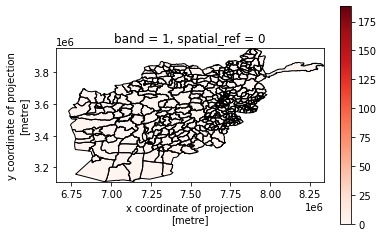

In [38]:
# Overlay vector and raster to check CRS match
f, ax = plt.subplots()
pop_repro.plot.imshow(ax=ax, cmap='Reds')
admin.plot(ax=ax, facecolor='none')
plt.show()

In [ ]:
# Save reprojected raster to tif
pop_repro.rio.to_raster("planet_scope.tif")

In [76]:
# Function for calculating zonal stats
# https://gis.stackexchange.com/questions/177035/using-geopandas-with-rasterstats-for-zonal-statistic-gives-error

def ZonalStats(shape_gdf, raster, stats):
    # shape - shapefile path
    # raster - raster path
    # stats - stats as list, f.e. 'min mean max' ; 'min'
    # the result is final_gdf as GeoDataFrame

    #shape_gdf = gpd.read_file(shape)
    zonalSt = rasterstats.zonal_stats(shape_gdf, raster, stats = stats)
    df = pd.DataFrame(zonalSt)
    df_concat = pd.concat([df, shape_gdf], axis=1)
    final_gdf = gpd.GeoDataFrame(df_concat, geometry=df_concat.geom)
    
    final_gdf_ordered = final_gdf[[c for c in final_gdf if c not in [stats]] + [stats]]
    
    return final_gdf_ordered

In [82]:
new_df = ZonalStats(admin, r'planet_scope.tif','sum')

In [83]:
new_df

,id,geom,shape_leng,shape_area,adm2_en,adm2_da,adm2_pcode,adm2_ref,adm2alt1en,adm2alt2en,...,adm0_da,adm0_pcode,date,validon,validto,reg_en,reg_da,reg_pcode,geometry,sum
0,1,"MULTIPOLYGON (((7867133.864 3802368.500, 78671...",0.803005,0.024570,Khash,خاش,AF1705,None,None,None,...,افغانستان,AF,2017-12-12,2021-11-17,None,North Eastern,سهیل ختیځه حوزه,NE,"MULTIPOLYGON (((7867133.864 3802368.500, 78671...",48635.539062
1,2,"MULTIPOLYGON (((7616915.466 3779589.826, 76168...",3.296682,0.211078,Hazrat-e-Sultan,حضرت سلطان,AF2002,None,None,None,...,افغانستان,AF,2017-12-12,2021-11-17,None,Northern,سهیلی حوزه,NR,"MULTIPOLYGON (((7616915.466 3779589.826, 76168...",103192.367188
2,3,"MULTIPOLYGON (((7670834.369 3570001.122, 76708...",1.984007,0.110332,Pul-e-Alam,پل علم,AF0501,None,Centre,None,...,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,"MULTIPOLYGON (((7670834.369 3570001.122, 76708...",149591.328125
3,118,"MULTIPOLYGON (((7600682.499 3516871.898, 76005...",1.197111,0.057921,Jaghatu,جغتو,AF0408,None,None,None,...,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,"MULTIPOLYGON (((7600682.499 3516871.898, 76005...",65922.984375
4,119,"MULTIPOLYGON (((7000888.350 3469192.256, 70009...",3.889667,0.531777,Bala Buluk,بالا بلوک,AF3306,None,None,None,...,افغانستان,AF,2017-12-12,2021-11-17,None,Western,لویدیځه حوزه,WR,"MULTIPOLYGON (((7000888.350 3469192.256, 70009...",110262.289062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,397,"MULTIPOLYGON (((7777453.775 3492136.175, 77773...",1.335641,0.045657,Musa Khel,موسی خیل,AF1405,None,None,None,...,افغانستان,AF,2017-12-12,2021-11-17,None,South Eastern,جنوب ختیځه حوزه,SE,"MULTIPOLYGON (((7777453.775 3492136.175, 77773...",81478.531250
397,398,"MULTIPOLYGON (((7190501.742 3763962.455, 71911...",2.748945,0.267424,Dawlat Abad,دولت آباد,AF2909,None,None,None,...,افغانستان,AF,2017-12-12,2021-11-17,None,Northern,سهیلی حوزه,NR,"MULTIPOLYGON (((7190501.742 3763962.455, 71911...",66114.054688
398,399,"MULTIPOLYGON (((7705312.929 3619450.132, 77052...",0.888306,0.021106,Qara Bagh,قره باغ,AF0114,None,None,None,...,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,"MULTIPOLYGON (((7705312.929 3619450.132, 77052...",105238.539062
399,400,"MULTIPOLYGON (((6990707.918 3666460.448, 69907...",2.719759,0.228261,Ab Kamari,آب کمری,AF3102,None,None,None,...,افغانستان,AF,2017-12-12,2021-11-17,None,Western,لویدیځه حوزه,WR,"MULTIPOLYGON (((6990707.918 3666460.448, 69907...",117488.445312


In [84]:
new_df['sum'].sum()

35038559.78479004